# Notebook 7: Population Decoding and Maximum Likelihood

Computational Biology 2 - WS 23/24

Material created by Katharina Bracher and Florian Eberhardt.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

## Simulation of recording data

To simulate the neurons we will use: 
- A linear variable (e.g. space, tone).
- Poisson spike statistics,
- A population of neurons with
- Gaussian tuningcurves
- maximal response of 100 spikes/sec

Neurons have random preferred orientations between 0-360° 


In [3]:
# Gaussian tuning, Poisson firing
def gaussian(A, x, sigma):
    return A*np.exp(-(x)**2/(2*sigma**2))

def poissonspikes(rate, time):
    spikes = []
    t = 0
    while t < time:
        t -= np.log(np.random.rand())/rate
        spikes.append(t)
    return spikes[:-1]

def get_spike_train(stimulus, preferred_stimulus, tuning_width=1., time=10., tuning_max=100):
    """
    stimulus: current stimulus
    preferred_stimulus: preferred stimulus of neuron
    tuning_width: width of tuning curves 
    tuning_max: max firing rate, amplitude of gaussian tuning curve
    time: total time of spike train
    """
    x = stimulus - preferred_stimulus
    mean_rate = gaussian(tuning_max, x, tuning_width)
    spike_train = poissonspikes(mean_rate, time)
    return np.array(spike_train)
    

In [4]:
x_0, x_max = 0., 10.  # range of encoded variable x
t_spike_train = 0.5 # seconds, duration of a spiketrain
n_neurons = 50
n_stimuli = 36
n_test = 5  # number of test stimuli
preferred_stimulus = np.random.rand(n_neurons)*x_max
tuning_width = np.ones(n_neurons)*2.
stimuli_train = np.arange(n_stimuli)/n_stimuli*x_max
stimuli_test = np.arange(n_test)/n_test*x_max
rate_max = 100. # Hz

In [5]:
recordings_train = pd.DataFrame(index=range(n_neurons), columns=stimuli_train, dtype='object')
for stim in stimuli_train:
    for i, pref in enumerate(preferred_stimulus):
        st = get_spike_train(pref, stim, tuning_width=2., time=t_spike_train,)  
        recordings_train.loc[i,stim]=st.tostring()
        
recordings_test = pd.DataFrame(index=range(n_neurons), columns=stimuli_test, dtype='object')
for stim in stimuli_test:
    for i, pref in enumerate(preferred_stimulus):
        st = get_spike_train(pref, stim, t_spike_train)  
        recordings_test.loc[i,stim]=st.tostring()

In [6]:
def read_spike_times(recordings, neuron, stim_orientation):
    st = recordings.loc[neuron, stim_orientation]
    st = np.frombuffer(st, dtype=float)
    return st

def estimate_rate(recordings, neuron, stim_orientation, t):
    st = read_spike_times(recordings, neuron, stim_orientation)
    r = len(st)/t
    return r

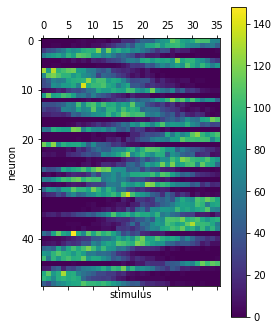

In [7]:

rates_train = np.zeros((n_neurons,n_stimuli))
for ni in range(n_neurons):
    for j,soj in enumerate(stimuli_train):
        rates_train[ni,j] = estimate_rate(recordings_train,ni,soj,t_spike_train)
mat = plt.matshow(rates_train)
plt.ylabel('neuron')
plt.xlabel('stimulus')
cbar = plt.colorbar(mat)

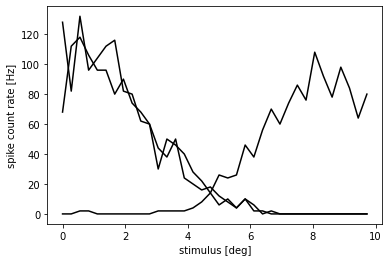

In [8]:
plt.plot(stimuli_train,rates_train[5:8].transpose(),'k-')
plt.xlabel('stimulus [deg]')
plt.ylabel('spike count rate [Hz]')
plt.show()

### Log Likelihood Function

In [9]:
import math
factorial_look_up  = np.array([np.float(math.factorial(n)) for n in range(171)])

def factorial(n):
    return factorial_look_up[int(n)]

factorial(4)

24.0

In [13]:
def gaussian_tuning_curve(s_x, s_a, sigma_a, r_max=rate_max):
    f = r_max * np.exp(-0.5 * np.square((s_x - s_a) / sigma_a))
    return f

def probability_poisson(s_x, r_a, s_a, sigma_a):
    f_a = gaussian_tuning_curve(s_x, s_a, sigma_a)
    count = r_a * t_spike_train
    t = t_spike_train
    return (f_a*t)**count / factorial(count) * np.exp(-f_a*t)

def log_likelihood(params, recordings):
    """
    params: [s_a, sigma_a]
    recordings: [s_x, r_a] where s_x and r_a are arrays/lists
    """
    s_a, sigma_a = params
    
    l = 0.
    for s, r in np.transpose(recordings):
        l += np.log(probability_poisson(s, r, s_a, sigma_a))
        
    return l

preferred orientation:  6.899843026012271


/tmp/ipykernel_16645/3231331890.py:20: RuntimeWarning: divide by zero encountered in log
  l += np.log(probability_poisson(s, r, s_a, sigma_a))


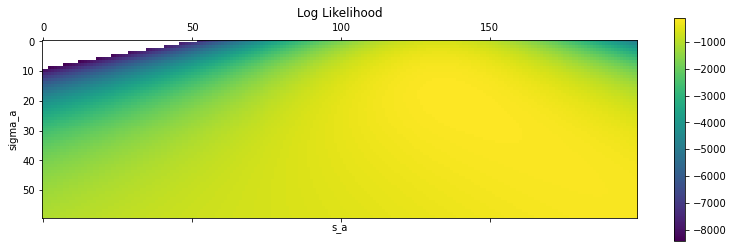

-89.61749455386544


In [14]:
neuron = 4
print('preferred orientation: ', preferred_stimulus[4])
s_a =  np.linspace(0,10,200)
sigma_a = np.arange(1,4,0.05)
r_a = rates_train[neuron]
s_x = stimuli_train
s_a, sigma_a = np.meshgrid(s_a, sigma_a)
ll = log_likelihood([s_a, sigma_a],[s_x, r_a])


mat = plt.matshow(ll)
plt.title('Log Likelihood')
plt.xlabel('s_a')
plt.ylabel('sigma_a')
plt.colorbar(mat)
plt.show()

print(np.max(ll))

### Read out maximum

In [15]:
mle_index = np.where(ll==np.max(ll))
s_a[mle_index], sigma_a[mle_index]

(array([6.98492462]), array([2.]))

### Population vector

In [16]:
np.sum(s_x * r_a) / np.sum(r_a)

6.659981280919909

### Numerical optimization

In [17]:
from scipy.optimize import minimize

def neg_log_likelihood(params, recordings):
    return -1.*log_likelihood(params, recordings)

x_0 = (8.,1.5)
minimize(neg_log_likelihood, x_0,  [s_x, r_a])

      fun: 89.57094791390092
 hess_inv: array([[0.00837784, 0.00277665],
       [0.00277665, 0.00354393]])
      jac: array([1.90734863e-06, 2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([6.96106287, 2.00019551])

### Decoding

In [ ]:
stim_index = 30
print('stimulus:', stimuli_train[stim_index])
x_0 = (5.,2.)
minimize(neg_log_likelihood, x_0,  [preferred_stimulus, rates_train[:,stim_index]])